# **Cohn-Kanade Dataset (CK+)**

In [ ]:
!wget https://github.com/skanelo/Deep-Emotion-Recognition/blob/main/CK+48.rar?raw=true

--2022-04-14 19:04:02--  https://github.com/skanelo/Deep-Emotion-Recognition/blob/main/CK+48.rar?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/skanelo/Deep-Emotion-Recognition/raw/main/CK+48.rar [following]
--2022-04-14 19:04:03--  https://github.com/skanelo/Deep-Emotion-Recognition/raw/main/CK+48.rar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/skanelo/Deep-Emotion-Recognition/main/CK%2B48.rar [following]
--2022-04-14 19:04:03--  https://raw.githubusercontent.com/skanelo/Deep-Emotion-Recognition/main/CK%2B48.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected

In [ ]:
%%capture
!unrar x -Y "/content/CK+48.rar" "."

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from google.colab import drive

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
h,w = 48, 48
# Converting all the images into an array
def load_images_from_folder(folder, labels = 0):
    count = 0
    error_count = 0
    images = []
    for filename in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder,filename))
            img = cv2.resize(img, (h,w)) ## Resizing the images
            ## for eyes if it is 0: open, 1: close
            images.append([img, labels])
        # need a try or except or else it will give an error when resizing the images
        except:
          error_count += 1
          print('ErrorCount = ' + str(error_count))
          continue
        count += 1
        if count % 100 == 0:
          print('Succesful Image Import Count = ' + str(count))

    return images

In [ ]:
# Pulling open eye images from directory and passing through image loading function
folder1="/content/CK+48/anger"
anger = load_images_from_folder(folder1, 0)

# Pulling closed eye images from directory and passing through image loading function
folder1="/content/CK+48/disgust"
disgust = load_images_from_folder(folder1, 1)

# Pulling open eye images from directory and passing through image loading function
folder2="/content/CK+48/fear"
fear = load_images_from_folder(folder2, 2)

# Pulling closed eye images from directory and passing through image loading function
folder3="/content/CK+48/happy"
happy = load_images_from_folder(folder3, 3)

# Pulling open eye images from directory and passing through image loading function
folder4="/content/CK+48/sadness"
sadness = load_images_from_folder(folder4, 4)

# Pulling closed eye images from directory and passing through image loading function
folder5="/content/CK+48/surprise"
surprise = load_images_from_folder(folder5, 5)

Succesful Image Import Count = 100
Succesful Image Import Count = 100
Succesful Image Import Count = 100
Succesful Image Import Count = 200
Succesful Image Import Count = 100
Succesful Image Import Count = 100
Succesful Image Import Count = 200


In [ ]:
# combining the open and closed eye data 
labels = anger+disgust+fear+happy+sadness+surprise
len(labels)

978

In [ ]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="#Images");
    ax.grid()


def load_data(data_path):
    """
    Load the dataset to the memory.
  
    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts
   
    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            face_array=cv2.resize(pixels, None, fx=1, fy=1,interpolation = cv2.INTER_CUBIC)
        
            img_data_list.append(face_array)          
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels, 6)

    data_visualization(subfolders_ck, num_images_per_class)
    data = np.array(img_data_list)
    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 207 images of category happy
Loading : 249 images of category surprise
Loading : 84 images of category sadness
Loading : 177 images of category disgust
Loading : 135 images of category anger
Loading : 75 images of category fear

Total number of uploaded data:  927 , with data shape (48, 48, 3)


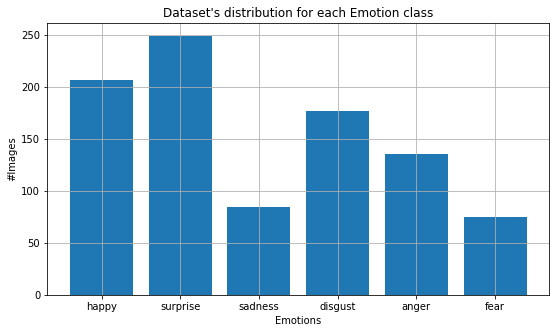

In [ ]:
data_path_ck = "/content/CK+48"
data, clabels = load_data(data_path_ck)

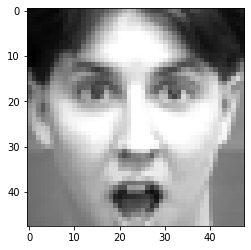

In [ ]:
X = []
y = []

for features, label in labels:
    X.append(features)
    y.append(label)

# Data must be in array form for modeling
X = np.array(X).reshape(-1, h, w, 3)
y = np.array(y)

X = X/255.0

# Setting up Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 24)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure()
plt.imshow(X_train[6])
plt.show()

In [ ]:
print(X_train.shape, X_test.shape)

(733, 48, 48, 3) (245, 48, 48, 3)


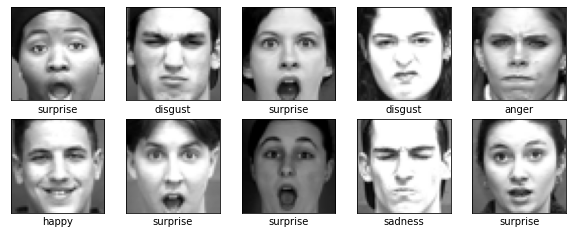

In [ ]:
## for the images below
class_names = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Code to produce ten pictures from the training dataset with corresponding lable
plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

In [ ]:
# Initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15,
                              zoom_range=0.15,
                              #width_shift_range=0.2,
                              brightness_range=(.6, 1.2),
                              shear_range=.15,
                              #height_shift_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest")

train_datagen = ImageDataGenerator(
  rescale=1/255,
  validation_split=0.4,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# **Model**

In [ ]:
# Reshape each image to be hxwx3 just in case on the top it didn't resize the image.
X_train = X_train.reshape(X_train.shape[0], h, w, 3)
X_test = X_test.reshape(X_test.shape[0], h, w, 3)

import tensorflow as tf

# Instantiate the model
model = Sequential()

# Adding first conv 2d layer
model.add(Conv2D(
                filters = 32, # number of filters
                kernel_size = (3,3), # height/width of filter
                activation = 'relu', # activation function 
                input_shape = (h,w,3) # shape of input (image)
))

# Adding pooling after conv 2d layer
model.add(MaxPooling2D(pool_size = (2,2))) # Dimensions of the region that you are pooling

# Add another convolutional layer.
model.add(Conv2D(
                filters = 32, # number of filters
                kernel_size = (3,3),# height/width of filter
                activation = 'relu'# activation function 
))

# Add another pooling layer.
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Adding first dense layer with 256 nodes
model.add(Dense(256, activation='relu'))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.4))

# Adding a dense layer
model.add(Dense(512, activation='relu'))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.4)) 

model.add(Dense(1024, activation='relu'))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.4))

model.add(Dense(len(class_names), activation = 'softmax'))

floss=tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction='sum'
)

model.compile(loss=floss, metrics=['accuracy'],optimizer='adam')
  
model.fit(X_train, y_train, batch_size=32,
            # # Comment out validation_data line to export the model
            #validation_data=(X_test, y_test),
            epochs=50)

Epoch 1/50
23/23 [==============================] - 10s 13ms/step - loss: 56.1166 - accuracy: 0.2005
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 51.4448 - accuracy: 0.3356
Epoch 3/50
23/23 [==============================] - 0s 9ms/step - loss: 33.8231 - accuracy: 0.5443
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 23.9925 - accuracy: 0.6480
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 15.9991 - accuracy: 0.7749
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 11.6175 - accuracy: 0.8199
Epoch 7/50
23/23 [==============================] - 0s 8ms/step - loss: 10.8644 - accuracy: 0.8090
Epoch 8/50
23/23 [==============================] - 0s 9ms/step - loss: 9.5132 - accuracy: 0.8199
Epoch 9/50
23/23 [==============================] - 0s 9ms/step - loss: 8.5870 - accuracy: 0.8240
Epoch 10/50
23/23 [==============================] - 0s 9ms/step - loss: 9.3685 - accuracy: 0.8363
Epoch 11/5

In [ ]:
EPOCHS = 10
batch_size = 64
filepath = "weights.best.hdf5"

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='auto', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, earlystopping, rlrop]

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(trainAug.flow(X_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_test, y_test),
                 epochs=EPOCHS, callbacks=callbacks)

In [ ]:
# Evaluate model on test data.
score = model.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

8/8 [==============================] - 0s 11ms/step - loss: 6.1265 - accuracy: 0.8531
loss: 6.1265058517456055
accuracy: 0.8530611991882324


In [ ]:
model.save('CK+50_tf.h5')

In [ ]:
preds = model.predict(X_test)
#preds.round(1)
preds=np.argmax(preds,axis=1)
preds

array([5, 5, 2, 5, 3, 1, 4, 5, 1, 3, 5, 2, 1, 4, 1, 4, 3, 1, 3, 3, 4, 4,
       3, 3, 4, 5, 3, 1, 3, 5, 2, 5, 4, 4, 3, 3, 5, 3, 1, 3, 1, 1, 4, 3,
       4, 5, 5, 1, 1, 4, 3, 3, 5, 4, 5, 3, 3, 1, 4, 3, 4, 4, 5, 3, 1, 5,
       1, 4, 3, 1, 5, 4, 4, 1, 0, 2, 5, 5, 0, 4, 1, 1, 3, 5, 5, 5, 1, 5,
       3, 4, 1, 5, 2, 4, 1, 1, 4, 4, 5, 4, 1, 2, 3, 5, 4, 4, 5, 5, 1, 4,
       1, 5, 4, 4, 5, 4, 3, 4, 3, 4, 2, 3, 1, 5, 2, 3, 5, 1, 4, 5, 4, 4,
       5, 3, 5, 3, 4, 5, 3, 3, 2, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 1, 4, 5,
       1, 5, 4, 3, 4, 4, 5, 1, 3, 3, 1, 4, 4, 1, 3, 3, 0, 5, 1, 5, 5, 2,
       2, 5, 3, 4, 5, 1, 5, 1, 5, 5, 5, 4, 2, 2, 5, 2, 5, 4, 5, 2, 5, 5,
       2, 3, 4, 4, 4, 2, 4, 1, 4, 3, 3, 4, 1, 1, 5, 1, 5, 2, 4, 1, 1, 4,
       4, 4, 1, 0, 5, 1, 3, 4, 1, 5, 5, 3, 3, 4, 2, 5, 5, 3, 4, 5, 4, 5,
       5, 4, 3])

In [ ]:
confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=preds.round()).numpy()

confusion_matrix

array([[ 1,  0,  0,  0, 33,  0],
       [ 0, 44,  0,  0,  0,  0],
       [ 0,  0, 19,  0,  0,  0],
       [ 0,  0,  0, 52,  0,  0],
       [ 3,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0, 62]], dtype=int32)

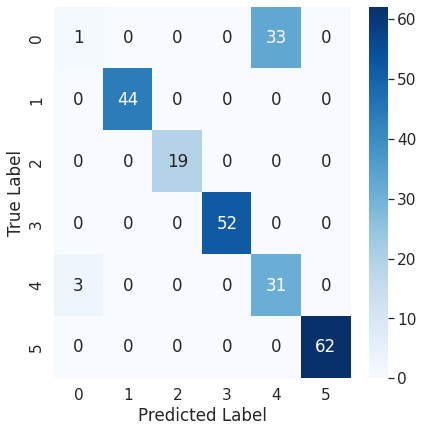

In [ ]:
import seaborn as sns

figure = plt.figure(figsize=(6,6))

sns.set(font_scale=1.4)

sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues, fmt='g')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix.ravel()

# Calculate the specificity
specificty = tn / (tn + fp)
print(f'specificity: {specificty}')

# Sensitivity
sensitivity = tp / (tp + fn)
print(f'sensitivity / recall: {sensitivity}')

# Accuracy
accuracy = (tn + tp) / (tn + fp + fn + tp)
print(f'accuracy: {accuracy}')

# Precision
precision = tp / (tp + fp)
print(f'precision: {precision}')

In [ ]:
import numpy as np
import time
from PIL import Image, ImageDraw
import tensorflow as tf

cropped_eye = Image.open('/content/CK+48/happy/S011_006_00000013.png')

# update name of model you will be saving
saved_model = tf.keras.models.load_model('CK+50_tf.h5')

def run_saved_model(model, eye_img):
    arr = np.asarray(eye_img)
    arr = cv2.resize(arr, (h,w)) ## Resizing the images
    arr = arr.reshape(1, h, w, 3)
    prediction = model.predict(arr)[0][0].round()
    return prediction

prediction = run_saved_model(saved_model, cropped_eye)

print("Predicted:",prediction)

plt.imshow(cropped_eye);

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
base_dir="/content/CK+48"
valid_datagen = ImageDataGenerator(
  rescale=1/255,
)

valid_generator = valid_datagen.flow_from_directory(
  base_dir,
  target_size=(h,w),
  class_mode='categorical',
  batch_size=4,
  shuffle=False)

Found 927 images belonging to 6 classes.


In [ ]:
images=next(valid_generator)
len(images)

2

GT: surprise, Pred: surprise
GT: disgust, Pred: disgust
GT: surprise, Pred: surprise
GT: disgust, Pred: disgust
GT: sadness, Pred: anger
GT: happy, Pred: happy


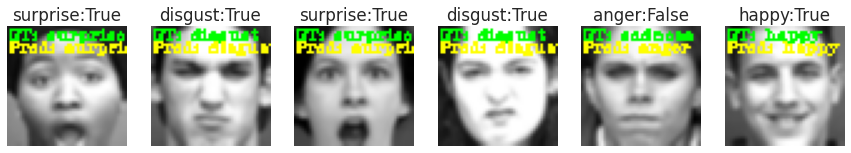

In [ ]:
import cv2

# Class names.
class_names = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Code to produce ten pictures from the training dataset with corresponding lable
fig=plt.figure(figsize=(15,15))
for i in range(6):
    image= X_train[i]#images[0][i]
    label= y_train[i]#np.argmax(images[1][i], axis=0)
    #plt.imshow(X_train[i], cmap = plt.cm.binary)
    #plt.xlabel(class_names[y_train[i]],)
    #image = np.asarray(image)
    arr = cv2.resize(image, (h,w)) ## Resizing the images
    arr = image.reshape(1, h, w, 3)
    prediction = model.predict(arr)
    prediction=np.argmax(prediction,axis=1)
    gt_class_name= class_names[int(prediction)]
    pred_class_name = class_names[label]
    print(f"GT: {gt_class_name}, Pred: {pred_class_name}")

    sub = fig.add_subplot(1, 6, i+1)
    sub.set_title(class_names[label] + ":" + str(int(prediction)==label))
    plt.axis('off')
    #image = np.array(image/np.amax(image)*255, np.int32) # if int
    image=(image*255).astype('uint16')
    image = cv2.GaussianBlur(np.ascontiguousarray(image), (3, 3), 0)
    # Annotate the image with ground truth.
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    thick = 1
    font_size = 0.3
    text1=f"GT: {gt_class_name}"
    text2=f"Pred: {pred_class_name}"
    
    image=cv2.putText(
        image, text1,
        (0,5), font, font_size, (0,255,0), thick, lineType=cv2.LINE_AA
    )
    image=cv2.putText(
        image, text2,
        (0,10), font, font_size, (255,255,0), thick, lineType=cv2.LINE_AA
    )
  
    plt.imshow(image)
plt.show()